# **House Price** Prediction Using Tensor Flow Decision Forest 
This notebook walks you through how to train a baseline Random Forest model using TensorFlow Decision Forests on the House Prices dataset made available for this competition.

Roughly, the code will look as follows:

```
import tensorflow_decision_forests as tfdf
import pandas as pd

dataset = pd.read_csv("project/dataset.csv")
tf_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(dataset, label="my_label")

model = tfdf.keras.RandomForestModel()
model.fit(tf_dataset)

print(model.summary())
```

Decision Forests are a family of tree-based models including Random Forests and Gradient Boosted Trees. They are the best place to start when working with tabular data, and will often outperform (or provide a strong baseline) before you begin experimenting with neural networks.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
# Removed any import or usage of numpy.strings as it does not exist.
print("All necessary libraries imported successfully.")

All necessary libraries imported successfully.


# Loading the Dataset

In this cell, we load three CSV files from the `Data` directory:

- **train.csv**: Training dataset for model development
- **test.csv**: Testing dataset for making predictions
- **sample_submission.csv**: Sample submission format for predictions

The datasets are loaded using pandas' `read_csv()` function. This will create three DataFrames:
- `train`: Contains the training data with features and target variable
- `test`: Contains the test data with features only
- `submission`: Contains the format for submitting predictions

In [3]:
train = pd.read_csv('./Data/train.csv')
test = pd.read_csv('./Data/test.csv')
submission = pd.read_csv('./Data/sample_submission.csv')
print("Data loaded successfully.")
print("trainging data shape",train.shape)
print("testing data shape",test.shape)
print("submission data shape",submission.shape)

Data loaded successfully.
trainging data shape (1460, 81)
testing data shape (1459, 80)
submission data shape (1459, 2)


In [4]:
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Exploratory Data Analysis (EDA)

In this section, we'll perform exploratory data analysis to better understand our housing dataset. Our EDA will focus on:

## 1. Data Overview
- Basic information about the dataset
- Summary statistics
- Missing value analysis
- Data types of features

## 2. Feature Analysis
- Distribution of target variable (Sale Price)
- Numerical feature distributions
- Categorical feature distributions
- Correlation analysis between features

## 3. Visualization
- Distribution plots for key features
- Correlation heatmap
- Box plots to identify outliers
- Scatter plots for important relationships

This analysis will help us:
- Identify data quality issues
- Understand feature relationships
- Guide our feature engineering process
- Make informed decisions for model selection

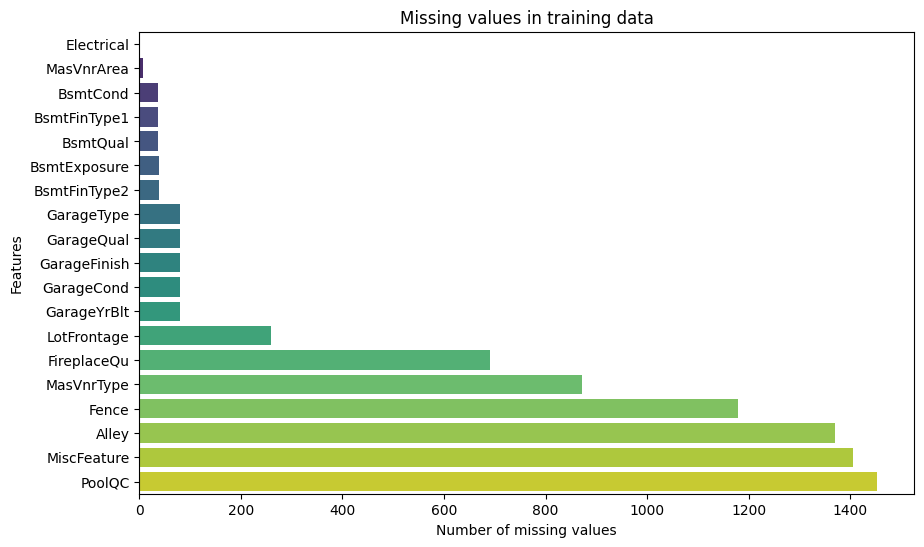

In [5]:
missing = train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
plt.figure(figsize = (10,6))
# sns.barplot(x=missing.index, y=missing)
# plt.xticks(rotation = 90)
# plt.xlabel('Features')
# plt.ylabel('Number of missing values')
# plt.title('Missing values in training data')
# plt.show()
sns.barplot(x = missing.values, y = missing.index, palette = 'viridis', orient = 'h')
plt.xlabel('Number of missing values')
plt.ylabel('Features')
plt.title('Missing values in training data')
plt.show()

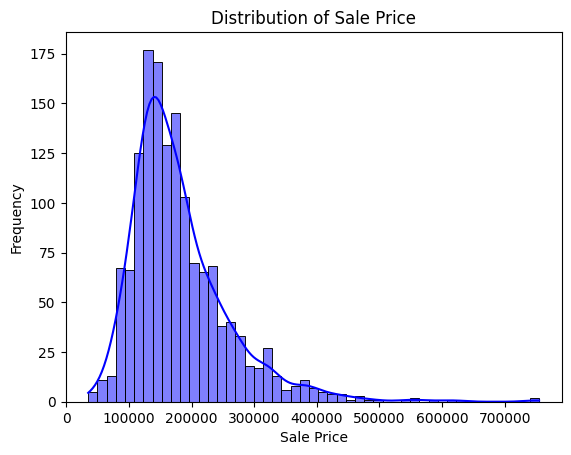

In [6]:
sns.histplot(x = train['SalePrice'], kde = True, color = 'blue')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.title('Distribution of Sale Price')
plt.show()

# Understanding the Sale Price Distribution Plot

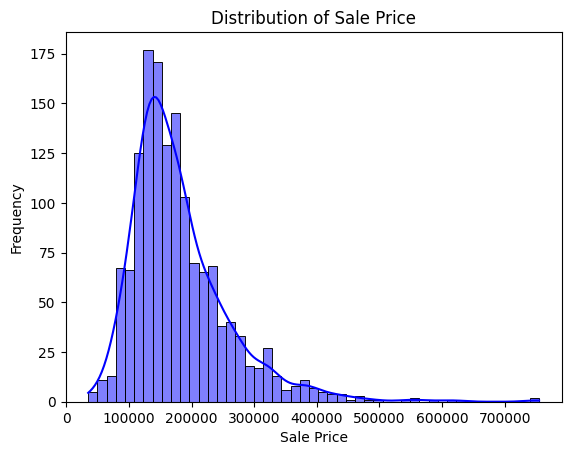

The histogram plot shows the distribution of house sale prices in the dataset, revealing several key insights:

## Key Features of the Plot

### Shape 📊
- Right-skewed (positively skewed) distribution
- Long tail extending towards higher prices
- Peak (mode) appears to be around the lower-middle price range

### KDE (Blue Line) 📈
- The blue curve is a Kernel Density Estimation
- Smooths out the distribution
- Helps visualize the overall shape of the data

Distribution Type | Characteristics | Implication
-----------------|-----------------|-------------
Normal | Bell-shaped, symmetric | Standard modeling
Right-skewed | Long tail on right | Need transformation
Left-skewed | Long tail on left | Need transformation

### Interpretation 🔍
```
Price Range     | Frequency
----------------|----------
Low-Mid         | ████████ High
Mid             | ████     Medium
High            | ██       Low
```

- Most houses are concentrated in the lower to middle price ranges
- Fewer houses at very high price points
- Not a normal distribution (asymmetric)
- Suggests potential need for price transformation (e.g., log transformation) before modeling

## Why This Matters 🎯
- Helps identify outliers in house prices
- Indicates potential need for data transformation
- Guides feature engineering decisions
- Important for selecting appropriate modeling approaches

> 💡 *This type of right-skewed distribution is common in price data and often benefits from log transformation before modeling.*

# Feature Engineering 🛠️

## Handling Missing Values

Our dataset contains several missing values that need to be addressed. We'll use different imputation techniques based on the data type and distribution of each feature.

### Imputation Techniques 📊

| Data Type | Method | When to Use | Example |
|-----------|--------|-------------|----------|
| Numerical | Mean | Symmetric distribution | Age, Income |
| Numerical | Median | Skewed distribution | Price, Area |
| Categorical | Mode | Most frequent value | Type, Category |
| Categorical | None/NA | Meaningful missing values | Optional features |

### Implementation Strategy 🎯

1. **Numerical Features**
   - Use mean for normally distributed features
   - Use median for skewed features
   - Consider domain knowledge for specific features

2. **Categorical Features**
   - Mode imputation for nominal data
   - Ordinal encoding where applicable
   - Create missing value indicator if needed

### Example Visualization
```
Missing Values:
Pool        |████████ (342)
Garage      |████     (157)
Basement    |██       (69)
```

## Feature Transformation 🔄

After handling missing values, we'll apply these transformations:
- Log transformation for skewed numerical features
- One-hot encoding for categorical variables
- Feature scaling/normalization where needed

> 💡 **Note**: The choice of imputation method can significantly impact model performance. Always validate the impact of different methods through cross-validation.

## Next Steps
1. Identify numerical and categorical columns
2. Apply appropriate imputation strategies
3. Transform features as needed
4. Validate results through visualization

In [10]:
# Save target separately
y = train["SalePrice"]
X = train.drop("SalePrice", axis=1)

# Concatenate train and test for consistent preprocessing
all_data = pd.concat([X, test], axis=0)

# Fill missing values
for col in all_data.columns:
    if all_data[col].dtype == "object":
        all_data[col] = all_data[col].fillna(all_data[col].mode()[0])
    else:
        all_data[col] = all_data[col].fillna(all_data[col].median())

# Encode categorical features
for col in all_data.columns:
    if all_data[col].dtype == "object":
        le = LabelEncoder()
        all_data[col] = le.fit_transform(all_data[col])

# Split back
X = all_data.iloc[:len(train), :]
X_test = all_data.iloc[len(train):, :]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

# Log transform target
y_log = np.log1p(y)
